In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
from IPython.display import display

# Options affichage
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
%matplotlib inline


In [2]:
file_path = "../data/arbolado-publico-lineal-2017-2018.csv"

print("Lecture du fichier:", file_path)
df = pd.read_csv(file_path, low_memory=False)
print("Shape:", df.shape)
df.head()


Lecture du fichier: ../data/arbolado-publico-lineal-2017-2018.csv
Shape: (370180, 18)


,long,lat,nro_registro,tipo_activ,comuna,manzana,calle_nombre,calle_altura,calle_chapa,direccion_normalizada,ubicacion,nombre_cientifico,ancho_acera,estado_plantera,ubicacion_plantera,nivel_plantera,diametro_altura_pecho,altura_arbol
0,-58.378563,-34.594902,26779,Lineal,1,NaN,Esmeralda,1000.0,1120.0,ESMERALDA 1120,NaN,Tipuana tipu,5.5,Ocupada,Regular,A nivel,88.0,34.0
1,-58.381532,-34.592319,30887,Lineal,1,NaN,Pellegrini Carlos,1300.0,1345.0,"PELLEGRINI, CARLOS 1345",Exacta,Peltophorum dubium,4.5,Ocupada,Regular,Elevada,6.0,5.0
2,-58.379103,-34.591939,30904,Lineal,1,NaN,Arroyo,800.0,848.0,ARROYO 848,Exacta,Fraxinus pennsylvanica,4,Ocupada,Regular,A nivel,7.0,6.0
3,-58.380710,-34.591548,31336,Lineal,1,NaN,Arroyo,900.0,932.0,ARROYO 932,LD,Fraxinus pennsylvanica,NaN,Ocupada,Regular,A nivel,9.0,29.0
4,-58.380710,-34.591548,31337,Lineal,1,NaN,Arroyo,900.0,932.0,ARROYO 932,LA,Jacaranda mimosifolia,NaN,Ocupada,Regular,A nivel,13.0,8.0


In [3]:
# Conversion des colonnes numériques
numeric_cols = ['long','lat','calle_altura','ancho_acera','diametro_altura_pecho','altura_arbol']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Nettoyage des noms d'espèces
if 'nombre_cientifico' in df.columns:
    df['nombre_cientifico_clean'] = (
        df['nombre_cientifico']
        .astype(str)
        .str.strip()
        .str.replace(r'\s+',' ', regex=True)
        .replace({'nan': None})
    )
    df.loc[df['nombre_cientifico_clean'].notna(), 'nombre_cientifico_clean'] = (
        df.loc[df['nombre_cientifico_clean'].notna(), 'nombre_cientifico_clean']
          .str.lower().str.title()
    )

print("Colonnes après nettoyage:", df.columns.tolist())
df[['nombre_cientifico','nombre_cientifico_clean']].head(10)


Colonnes après nettoyage: ['long', 'lat', 'nro_registro', 'tipo_activ', 'comuna', 'manzana', 'calle_nombre', 'calle_altura', 'calle_chapa', 'direccion_normalizada', 'ubicacion', 'nombre_cientifico', 'ancho_acera', 'estado_plantera', 'ubicacion_plantera', 'nivel_plantera', 'diametro_altura_pecho', 'altura_arbol', 'nombre_cientifico_clean']


,nombre_cientifico,nombre_cientifico_clean
0,Tipuana tipu,Tipuana Tipu
1,Peltophorum dubium,Peltophorum Dubium
2,Fraxinus pennsylvanica,Fraxinus Pennsylvanica
3,Fraxinus pennsylvanica,Fraxinus Pennsylvanica
4,Jacaranda mimosifolia,Jacaranda Mimosifolia
5,Fraxinus pennsylvanica,Fraxinus Pennsylvanica
6,Fraxinus pennsylvanica,Fraxinus Pennsylvanica
7,Jacaranda mimosifolia,Jacaranda Mimosifolia
8,Jacaranda mimosifolia,Jacaranda Mimosifolia
9,Tilia x moltkei,Tilia X Moltkei


In [4]:
missing = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_pct': (df.isna().sum() / len(df) * 100).round(3)
}).sort_values('missing_pct', ascending=False)
missing.head(30)


,missing_count,missing_pct
manzana,146040,39.451
long,15342,4.144
lat,15342,4.144
direccion_normalizada,14239,3.847
ubicacion,8296,2.241
calle_chapa,6459,1.745
calle_altura,5868,1.585
altura_arbol,4322,1.168
ancho_acera,3911,1.057
ubicacion_plantera,1404,0.379


In [5]:
dup_exact = df.duplicated().sum()
dup_coord_species = None
if {'long','lat','nombre_cientifico_clean'}.issubset(df.columns):
    dup_coord_species = df.duplicated(subset=['long','lat','nombre_cientifico_clean']).sum()

print("Doublons exacts:", dup_exact)
print("Doublons (long,lat,espèce):", dup_coord_species)


Doublons exacts: 0
Doublons (long,lat,espèce): 90472


In [6]:
desc_numeric = df.select_dtypes(include=[np.number]).describe().T
desc_numeric.head(40)


,count,mean,std,min,25%,50%,75%,max
long,354838.0,-58.458791,0.041514,-58.530458,-58.491269,-58.465865,-58.428583,-5.835400e+01
lat,354838.0,-34.612473,0.033695,-34.697333,-34.637834,-34.615023,-34.586580,-3.453597e+01
comuna,370180.0,9.143735,3.876242,1.000000,6.000000,10.000000,12.000000,1.500000e+01
calle_altura,364312.0,3107.527647,118719.446649,0.000000,1200.000000,2400.000000,3800.000000,3.900515e+07
ancho_acera,366269.0,3.785710,1.334402,0.400000,3.000000,3.500000,4.400000,2.800000e+01
diametro_altura_pecho,369894.0,31.986864,21.267623,0.000000,17.000000,29.000000,43.000000,1.990000e+02
altura_arbol,365858.0,9.036132,4.894625,1.000000,6.000000,8.000000,12.000000,4.000000e+01


In [7]:
if 'nombre_cientifico_clean' in df.columns:
    top_species = df['nombre_cientifico_clean'].value_counts(dropna=True).head(30).rename_axis('species').reset_index(name='counts')
    display(top_species)
else:
    print("Colonne 'nombre_cientifico' absente")


,species,counts
0,Fraxinus Pennsylvanica,133609
1,Platanus X Acerifolia,32319
2,Ficus Benjamina,22508
3,Tilia X Moltkei,15605
4,Melia Azedarach,14908
5,Jacaranda Mimosifolia,13872
6,Lagerstroemia Indica,11886
7,Fraxinus Americana,10119
8,No Identificado,9411
9,Tipuana Tipu,9330


In [8]:
if {'diametro_altura_pecho','altura_arbol'}.issubset(df.columns):
    sub = df[['diametro_altura_pecho','altura_arbol']].dropna()
    print("N observations pour corrélation:", len(sub))
    if len(sub) > 2:
        pearson = stats.pearsonr(sub['diametro_altura_pecho'], sub['altura_arbol'])
        spearman = stats.spearmanr(sub['diametro_altura_pecho'], sub['altura_arbol'])
        slope, intercept, r_value, p_value, std_err = stats.linregress(sub['diametro_altura_pecho'], sub['altura_arbol'])
        print(f"Pearson r = {pearson[0]:.4f}, p = {pearson[1]:.4g}")
        print(f"Spearman rho = {spearman.correlation:.4f}, p = {spearman.pvalue:.4g}")
        print(f"Régression linéaire: slope={slope:.4f}, intercept={intercept:.4f}, R2={r_value**2:.4f}")
    else:
        print('Pas assez d\'observations pour corrélation')
else:
    print('Colonnes diamètre/hauteur absentes')


N observations pour corrélation: 365624
Pearson r = 0.6562, p = 0
Spearman rho = 0.7015, p = 0
Régression linéaire: slope=0.1518, intercept=4.1409, R2=0.4306


In [9]:
if 'altura_arbol' in df.columns:
    ser = df['altura_arbol'].dropna()
    q1 = ser.quantile(0.25); q3 = ser.quantile(0.75); iqr = q3 - q1
    lower = q1 - 1.5*iqr; upper = q3 + 1.5*iqr
    outliers = df[(df['altura_arbol'] < lower) | (df['altura_arbol'] > upper)]
    print("Nombre d'outliers (altura_arbol):", len(outliers))
    outliers[['diametro_altura_pecho','altura_arbol']].head(10)
else:
    print("Colonne 'altura_arbol' absente")


Nombre d'outliers (altura_arbol): 8607


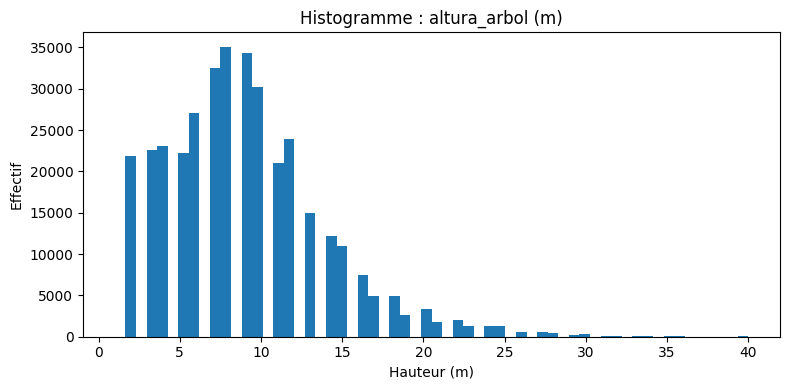

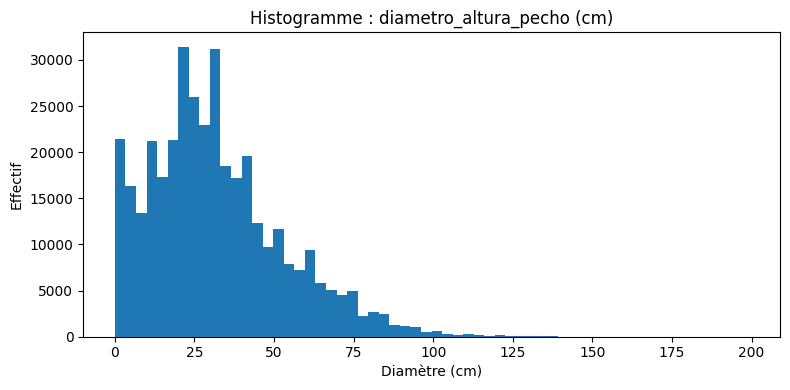

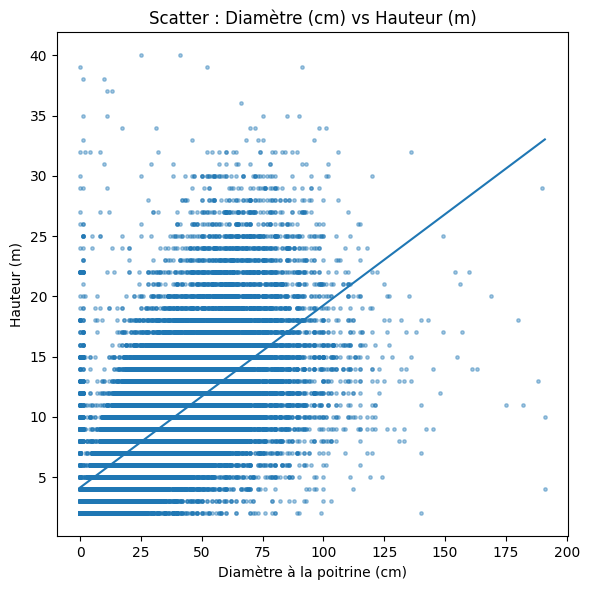

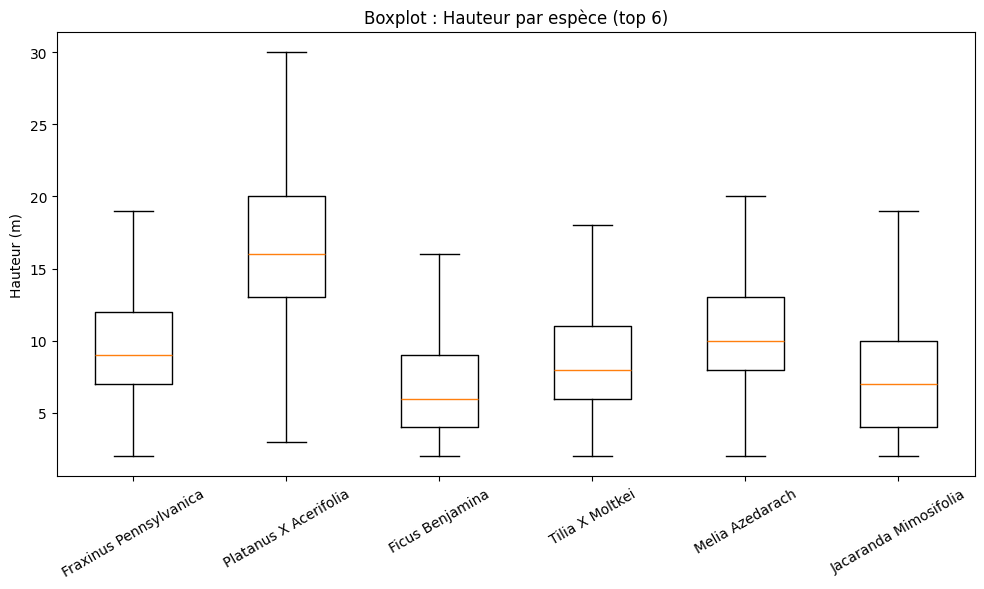

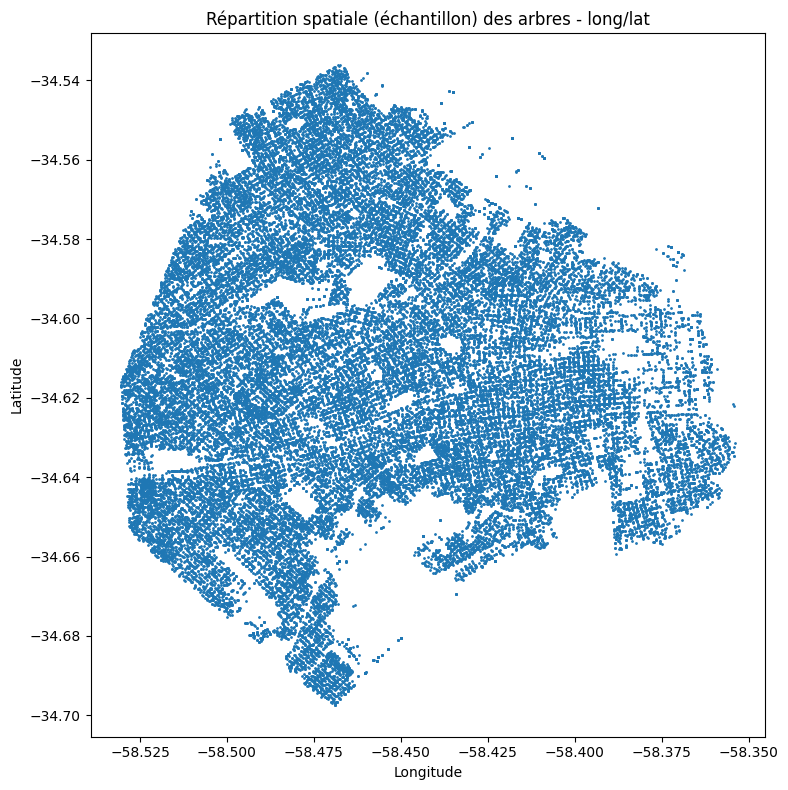

Plots sauvegardés dans: .


In [ ]:
out_dir = "."
os.makedirs(out_dir, exist_ok=True)

# Histogramme hauteur
if 'altura_arbol' in df.columns:
    plt.figure(figsize=(8,4))
    plt.hist(df['altura_arbol'].dropna(), bins=60)
    plt.title("Histogramme : altura_arbol (m)")
    plt.xlabel("Hauteur (m)")
    plt.ylabel("Effectif")
    plt.tight_layout()
    #plt.savefig(os.path.join(out_dir, "hist_altura_arbol.png"))
    plt.show()

# Histogramme diametre
if 'diametro_altura_pecho' in df.columns:
    plt.figure(figsize=(8,4))
    plt.hist(df['diametro_altura_pecho'].dropna(), bins=60)
    plt.title("Histogramme : diametro_altura_pecho (cm)")
    plt.xlabel("Diamètre (cm)")
    plt.ylabel("Effectif")
    plt.tight_layout()
    #plt.savefig(os.path.join(out_dir, "hist_diametro.png"))
    plt.show()

# Scatter diam vs hauteur
if {'diametro_altura_pecho','altura_arbol'}.issubset(df.columns):
    sub = df[['diametro_altura_pecho','altura_arbol']].dropna()
    n = min(50000, len(sub))
    sample = sub.sample(n=n, random_state=1)
    plt.figure(figsize=(6,6))
    plt.scatter(sample['diametro_altura_pecho'], sample['altura_arbol'], s=6, alpha=0.4)
    slope, intercept, r_value, p_value, std_err = stats.linregress(sample['diametro_altura_pecho'], sample['altura_arbol'])
    xs = np.array([sample['diametro_altura_pecho'].min(), sample['diametro_altura_pecho'].max()])
    ys = intercept + slope * xs
    plt.plot(xs, ys)
    plt.title("Scatter : Diamètre (cm) vs Hauteur (m)")
    plt.xlabel("Diamètre à la poitrine (cm)")
    plt.ylabel("Hauteur (m)")
    plt.tight_layout()
    #plt.savefig(os.path.join(out_dir, "scatter_diam_vs_alt.png"))
    plt.show()

# Boxplot top6 espèces
if 'nombre_cientifico_clean' in df.columns and 'altura_arbol' in df.columns:
    top6 = df['nombre_cientifico_clean'].value_counts().head(6).index.tolist()
    data_box = [df.loc[df['nombre_cientifico_clean'] == sp, 'altura_arbol'].dropna() for sp in top6]
    plt.figure(figsize=(10,6))
    plt.boxplot(data_box, labels=top6, showfliers=False)
    plt.title("Boxplot : Hauteur par espèce (top 6)")
    plt.ylabel("Hauteur (m)")
    plt.xticks(rotation=30)
    plt.tight_layout()
    #plt.savefig(os.path.join(out_dir, "boxplot_top6_species.png"))
    plt.show()

# Carte scatter long/lat
if {'long','lat'}.issubset(df.columns):
    sub = df.dropna(subset=['long','lat'])
    n = min(50000, len(sub))
    sample = sub.sample(n=n, random_state=2)
    plt.figure(figsize=(8,8))
    plt.scatter(sample['long'], sample['lat'], s=1)
    plt.title("Répartition spatiale (échantillon) des arbres - long/lat")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    #plt.savefig(os.path.join(out_dir, "map_scatter.png"))
    plt.show()

print("Plots sauvegardés dans:", out_dir)
